# Einfache lineare Regression und Residuenanalyse

Challenge: cml1/3Db Immobilienrechner <br/>
Team: Alexander Shanmugam, Si Ben Tran, Gabriel Torrez Gamez, Haris Alic <br/>
Aufgabe: 2.1 Einfache lineare Regression und Residuenanalyse

Verwende ein einfaches lineares Modell zur Vorhersage von `price_cleaned` mit dem Attribut `Space extracted` oder `Floor_space_merged` (es gibt einige, wo beide fehlen (um die 800, können ignoriert werden).

Entwickle das Modell in einem Notebook. Untersuche dabei ob die Annahmen eines linearen Modells erfüllt sind mit geeigneten Darstellungen. Wie können Variablen-Transformationen verwendet werden, um die Modellvoraussetzungen besser zu erfüllen und das Modell zu verbessern?

Rapportiere und diskutiere die erreichte Genauigkeit der Vorhersage mit mehreren sinnvollen Metriken und auf unabhängigen Testdaten.

Abgabe

Notebook und daraus erstellter Bericht (ohne Code) als pdf.

In [2]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Import sklearn modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# load raw dataframe 
#df = pd.read_csv("https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/immoscout_cleaned_lat_lon_fixed_v9.csv", usecols = ["Floor_space_merged", "Space extracted", "price_cleaned"])

df = pd.read_parquet('https://github.com/Immobilienrechner-Challenge/data/blob/main/immo_data_202208_v2.parquet?raw=true', columns  = ["Floor_space_merged", "Space extracted", "price_cleaned"])

# display DataFrame
display("DataFrame for simple linear Regression", df)

'DataFrame for simple linear Regression'

,Floor_space_merged,Space extracted,price_cleaned
0,None,100.0,1150000.0
1,242 m²,156.0,1420000.0
2,None,NaN,720000.0
3,257 m²,154.0,1430000.0
4,None,142.0,995000.0
...,...,...,...
22476,None,102.0,475000.0
22477,None,250.0,1490000.0
22478,None,240.0,1450000.0
22479,None,175.0,1290000.0


# Missing Values

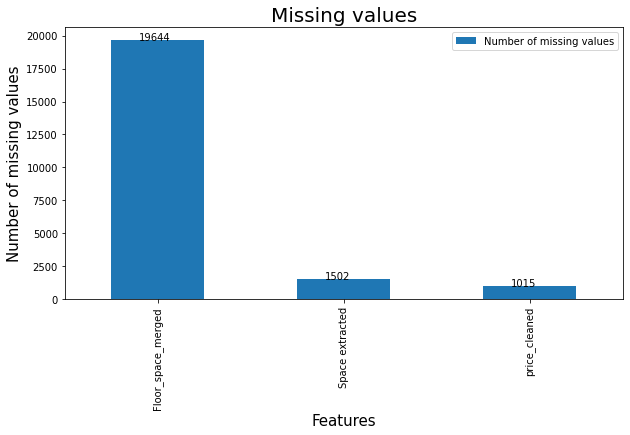

(22481, 3)

In [3]:
# Visualize missing values with barplot and number of missing value on top of each bar
def missing_values_barplot(df):
    """
    Visualize missing values with barplot and number of missing value on top of each bar
    Args:
        df (DataFrame): DataFrame with missing values
    """
    # Calculate number of missing values
    missing_values = df.isnull().sum().sort_values(ascending=False)
    # Concatenate number of missing values and percentage of missing values
    missing_values = pd.concat([missing_values], axis=1, keys=['Number of missing values'])
    # Plot barplot
    missing_values.plot(kind='bar', figsize=(10, 5))
    # Add number of missing values on top of each bar
    for i in range(len(missing_values)):
        plt.text(x = i-0.1 , y = missing_values['Number of missing values'][i], s = missing_values['Number of missing values'][i], size = 10)
    # Set title
    plt.title('Missing values', fontsize=20)
    # Set x-label
    plt.xlabel('Features', fontsize=15)
    # Set y-label
    plt.ylabel('Number of missing values', fontsize=15)
    # Display plot
    plt.show()

# Visualize missing values with barplot and number of missing value on top of each bar
missing_values_barplot(df)

# shape of dataframe
df.shape

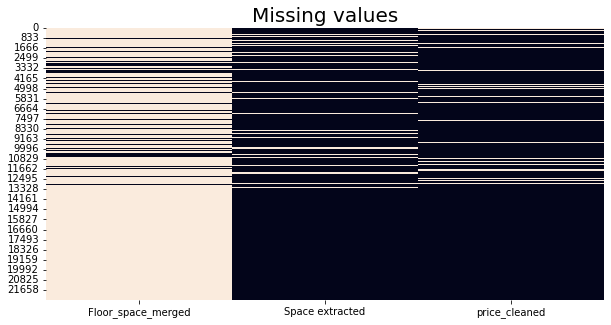

In [4]:
# Create heatmap isna map
def heatmap_isna(df):
    """
    Create heatmap isna map
    Args:
        df (DataFrame): DataFrame with missing values
    """
    # figure size
    plt.figure(figsize=(10, 5))
    # Create heatmap isna map
    sns.heatmap(df.isnull(), cbar=False)
    # Set title
    plt.title('Missing values', fontsize=20)
    # Display plot
    plt.show()

# Create heatmap isna map
heatmap_isna(df)

We are selecting space_extracted as feature and price_cleaned as target. 
Floor_space_merged wont be used for the linear regression modell, beceause there are over 10000 missing values out
from 13378 observations. in The heatmap Visualization we can also see, if the NaN values of price_cleaned and Space extracted are on the same rows. 
Before we will remove the NaN values, we will plot the distribution plot to see the effects, of removing NaN values.

# Distribution

we are plotting the distribution of space extracted and price cleaned to see, how the distritbution of our data looks like.

In [5]:
# drop rows with missing values
df = df[["price_cleaned", "Space extracted"]]

# display df
display("DataFrame selected", df.head(2))

'DataFrame selected'

,price_cleaned,Space extracted
0,1150000.0,100.0
1,1420000.0,156.0


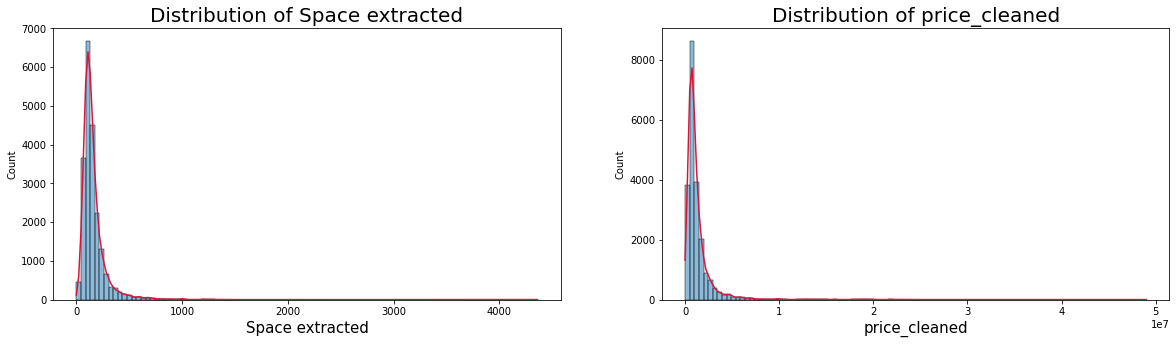

In [6]:
# Show Distribution of space_extracted and price_cleaned using histplot
def show_distribution(df, features, binsize = 100):
    """
    Show Distribution of space_extracted and price_cleaned
    Args:
        df (DataFrame): DataFrame with missing values
        feature (list): Features to show distribution
        binsize (int): Number of bins for histplot - default = 100
    """

    # use fig and ax to plot
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    # Plot histplot for space_extracted
    sns.histplot(df[features[0]], ax=ax[0], kde=True, bins = binsize)
    # Plot histplot for price_cleaned
    sns.histplot(df[features[1]], ax=ax[1], kde=True, bins = binsize)
    # Set title for space_extracted
    ax[0].set_title('Distribution of ' + features[0], fontsize=20)
    # add label for space_extracted
    ax[0].set_xlabel(features[0], fontsize=15)
    # add color to kde line
    ax[0].lines[0].set_color('crimson')    

    # set x range for space_extracted

    # Set title for price_cleaned
    ax[1].set_title('Distribution of ' + features[1], fontsize=20)
    # add label for price_cleaned
    ax[1].set_xlabel(features[1], fontsize=15)
    # add color to kde line
    ax[1].lines[0].set_color("crimson")
    # Display plot
    plt.show()


# Show Distribution of space_extracted and price_cleaned
show_distribution(df, features = ['Space extracted', 'price_cleaned'])


price_cleaned and space extracted are both right skewed distribution.
We will remove the Na values and will use the distribution function again. 

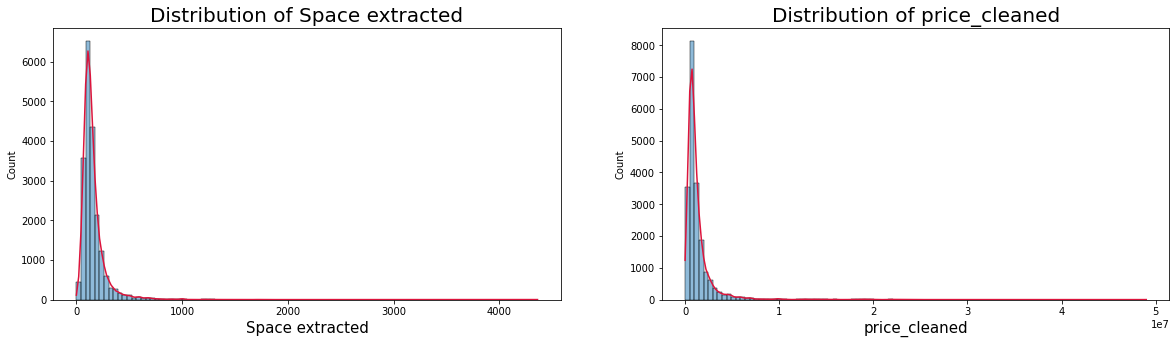

In [7]:
# drop na rows
df_clean = df.dropna()

# show distribution
show_distribution(df_clean, ['Space extracted', 'price_cleaned'])

Both distributions are still right skewed, but the space_extracted looks a little bit more like a normal distribution with a long tail to the right side. We will transform space_extraced and price_cleaned with sqrt, ln.

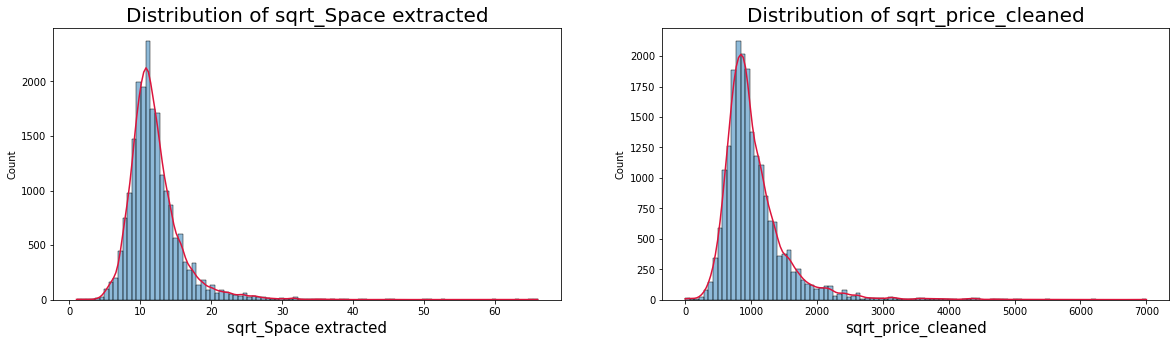

In [8]:
# copy DataFrame
df_clean_sqrt = df_clean.copy()

# np.sqrt space_extracted and price_cleaned
df_clean_sqrt['sqrt_Space extracted'] = np.sqrt(df_clean_sqrt['Space extracted'])
df_clean_sqrt['sqrt_price_cleaned'] = np.sqrt(df_clean_sqrt['price_cleaned'])

# show distribution
show_distribution(df_clean_sqrt, ['sqrt_Space extracted', 'sqrt_price_cleaned'])


If we are transforming Space_extraced and log_price with np.sqrt we can get a normal distribution. Lets try it with ln in the next step.

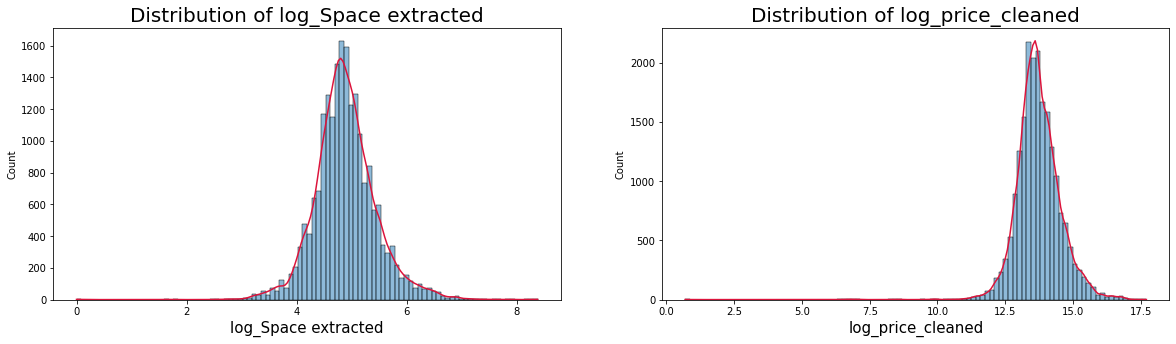

In [9]:
# copy DataFrame
df_clean_log = df_clean.copy()

# np.log space_extracted and price_cleaned
df_clean_log['log_Space extracted'] = np.log(df_clean_log['Space extracted'])
df_clean_log['log_price_cleaned'] = np.log(df_clean_log['price_cleaned'])

# show distribution
show_distribution(df_clean_log, ['log_Space extracted', 'log_price_cleaned'])


Same as with sqrt, the log is also transforming the feature and target into a normal distribution. In the next step we will concern us with the outliers.

# Simple Linear Regression 

In [10]:
# import sklearn modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

## Creating Linear Regression function with Residualanalysis

In [11]:
# Select interested cols
df_living_space_price = df_clean[['Space extracted', 'price_cleaned']]

# create x and y variabels for regression
space_extracted = df_living_space_price['Space extracted'].values.reshape(-1, 1)
price_cleaned = df_living_space_price['price_cleaned'].values.reshape(-1, 1)

In [12]:
# make cross validation
def cross_validation(model, x, y, cv=10):
    """
    Make cross validation
    Args:
        model (model): model to cross validate
        x (array): x values
        y (array): y values
        cv (int): number of cross validation
    """
    # make cross validation
    scores = cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_percentage_error')
    # print scores
    print("Cross validation scores: ", scores)
    # print mean score
    print("Cross validation mean score: ", scores.mean())
    # return scores
    return scores

model = LinearRegression()

# use function
cv_scores = cross_validation(model, space_extracted, price_cleaned)


# cross validation needs to be checked again! (Why is MAPE it negative?)

Cross validation scores:  [  -0.39474501 -290.63732997   -1.48002891   -0.80353531   -1.05846077
   -0.69007832   -0.91274734   -2.09516913   -1.75880476   -0.65135521]
Cross validation mean score:  -30.04822547303653


In [13]:
# create a function for sklear linear Regression model with cross validation
def linear_regression_model(x, y, test_size=0.2, random_state=42, x_transform = None, y_transform = None):
      """
      Create a function for sklear linear Regression model with cross validation
      Args:
            x (array): x variable for regression
            y (array): y variable for regression
            test_size (float): test size for cross validation
            random_state (int): random state for cross validation
            x_transform (str): transform x variable based on np.sqrt or np.log
            y_transform (str): transform y variable based on np.sqrt or np.log
      """
      # Labeling and transform x and y variable
      if x_transform == 'sqrt':
            x = np.sqrt(x)
            x_label = 'sqrt_Space extracted'
      elif x_transform == 'log':
            x = np.log(x)
            x_label = 'log_Space extracted'
      else:
            x_label = 'Space extracted'
      
      if y_transform == 'sqrt':
            y = np.sqrt(y)
            y_label = 'sqrt_price_cleaned'
      elif y_transform == 'log':
            y = np.log(y)
            y_label = 'log_price_cleaned'
      else:
            y_label = 'price_cleaned'
      
      title_scatter = x_label + ' and ' + y_label
      title_y_yhat =  x_label + ' True vs ' + x_label + ' Predicted'

      # Split data into training and testing sets
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

      # Create linear regression object 
      regr = LinearRegression()

      # Train the model using the training sets
      regr.fit(x_train, y_train)

      # Make predictions using the testing set
      y_pred = regr.predict(x_test)

      # transform y_pred and y_test to original scale
      if y_transform == 'sqrt':
            y_pred_metric = y_pred**2
            y_test_metric = y_test**2
      elif y_transform == 'log':
            y_pred_metric = np.exp(y_pred)
            y_test_metric = np.exp(y_test)
      else:
            y_pred_metric = y_pred
            y_test_metric = y_test            

      # the mean absolute error
      mae = np.round(mean_absolute_error(y_test_metric, y_pred_metric), 3)

      # the mean absolute percentage error
      mape = np.round(mean_absolute_percentage_error(y_test_metric, y_pred_metric), 3)
      
      # the mean squared error
      mse = np.round(mean_squared_error(y_test_metric, y_pred_metric), 3)

      # the R2 score
      r2 = np.round(r2_score(y_test_metric, y_pred_metric), 3)

      # Scatte plot and regression Trendline
      fig, ax = plt.subplots(1, 2, figsize=(20, 5))
      # Scatter plot for x and y
      ax[0].scatter(x_test, y_test, color='blue', alpha = 0.2)
      ax[0].plot(x_test, y_pred, color='red', alpha = 0.5, linestyle='--')
      ax[0].set_title(title_scatter, fontsize=20, y = 1.05)
      ax[0].set_xlabel(x_label, fontsize=15)
      ax[0].set_ylabel(y_label, fontsize=15)

      # Plot y_test and y_pred
      ax[1].scatter(y_test, y_pred, color='blue', alpha = 0.2)
      ax[1].plot(y_test, y_test, color='red', alpha = 0.5, linestyle='--')
      ax[1].set_title(title_y_yhat, fontsize=20, y = 1.05)
      ax[1].set_xlabel('True Values', fontsize=15)
      ax[1].set_ylabel('Predicted Values', fontsize=15)   

      # add fig.text
      fig.text(0.1, -0.1, f'MAE: {mae} | MAPE: {mape} | MSE: {mse} | R2: {r2}', ha='left', va="bottom" ,fontsize=10)
      plt.show()

      # Residuenanalyse
      # For the residueanalyse we are checking three conditions:
      # The error shouldn’t be dependent
      # The expected value should be around 0
      # The residuals should follow normal distribution
      
      # residual plot
      residuals = y_test - y_pred

      # standardize residuals
      standardized_residuals = (residuals - residuals.mean()) / residuals.std()

      # Residual plot
      fig, ax = plt.subplots(1, 2, figsize=(20, 5))
      # Residual Scatterplot
      ax[0].scatter(y_pred, standardized_residuals, color='blue', alpha = 0.2)
      # add horizontal line at 0
      ax[0].axhline(y=0, color='red', linestyle='--', alpha = 0.5)
      ax[0].set_title('Residual Plot', fontsize=20, y = 1.05)
      ax[0].set_xlabel('Predicted Values', fontsize=15)
      ax[0].set_ylabel('Standardized Residuals', fontsize=15)

      # distribution plot 
      sns.histplot(standardized_residuals, ax=ax[1], kde=True)
      ax[1].set_title('Distribution Plot', fontsize=20, y = 1.05)
      ax[1].set_xlabel('Standardized Residuals', fontsize=15)
      ax[1].set_ylabel('Frequency', fontsize=15)
      ax[1].axvline(x=0, color='red', alpha = 0.5, linestyle='--')
      plt.show()

# 1. Linear Regression with space extracted and price_cleaned

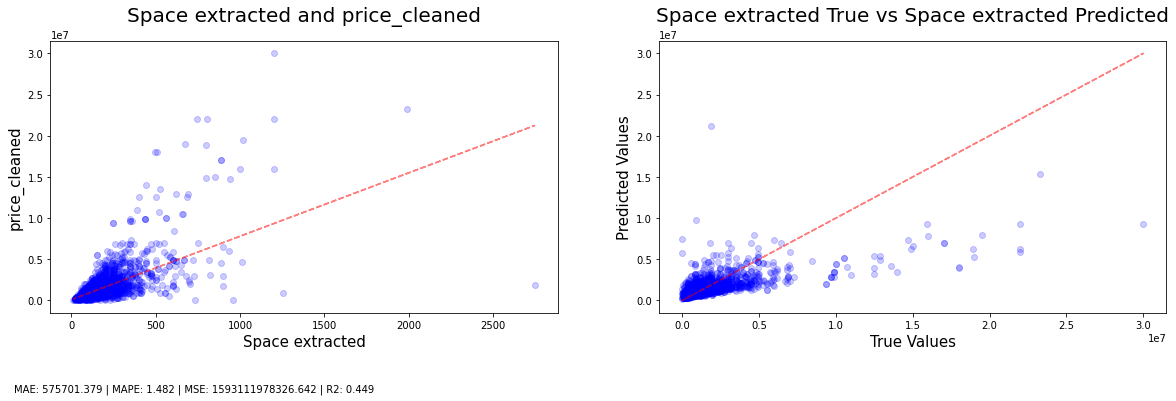

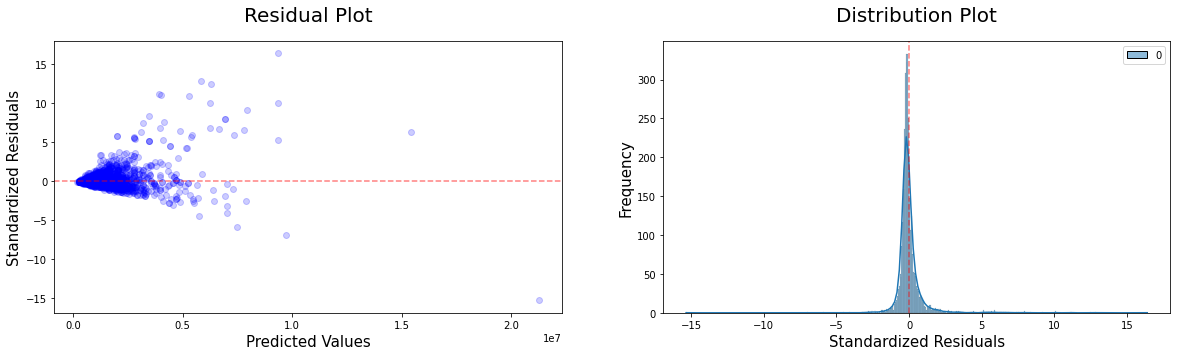

In [14]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "None", y_transform = "None")

## 1. Model interpretation and conclusion
- R2 Score of 0.114, MAPE of 0.908, thats not a good linear Model
- The resiudals are not independent. The values are not around 0.

We can try with log and sqrt transformation for the feature and/or target to check if the R2 is increasing and the MAPE 

# 2.1 Simple Lineare Regression with sqrt transformation of x-axis

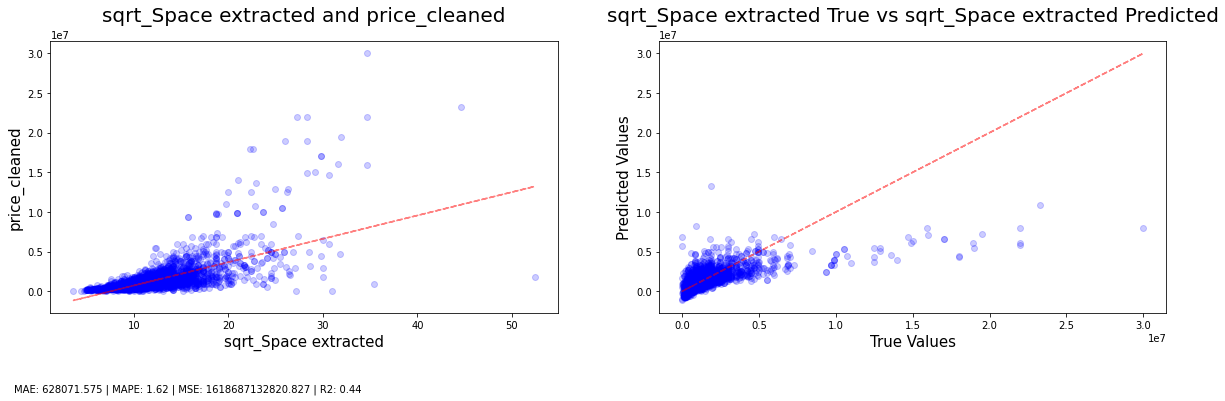

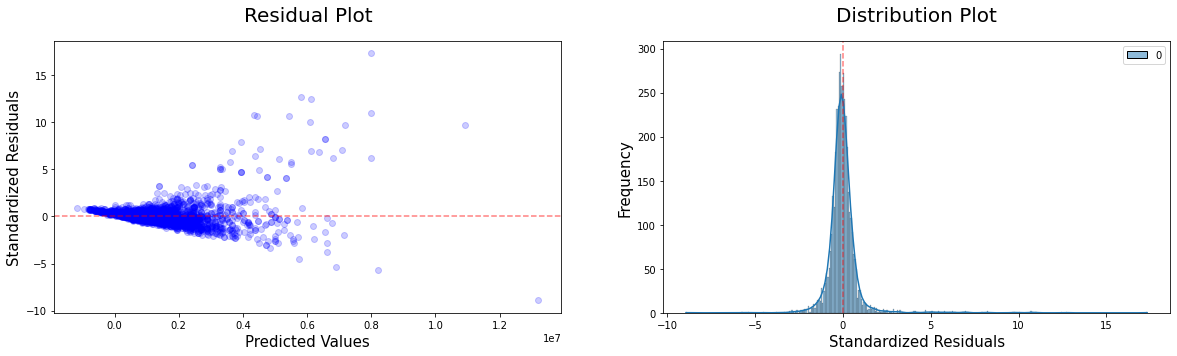

In [15]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "sqrt", y_transform = "None")

## 2.1 Model interpretation and conclusion
- R2 Score of 0.411, MAPE of 0.94, thats not a good linear Model
- The resiudals are not independent. The values are not around 0.

# 2.2 Simple Lineare Regression with sqrt transformation of y-axis

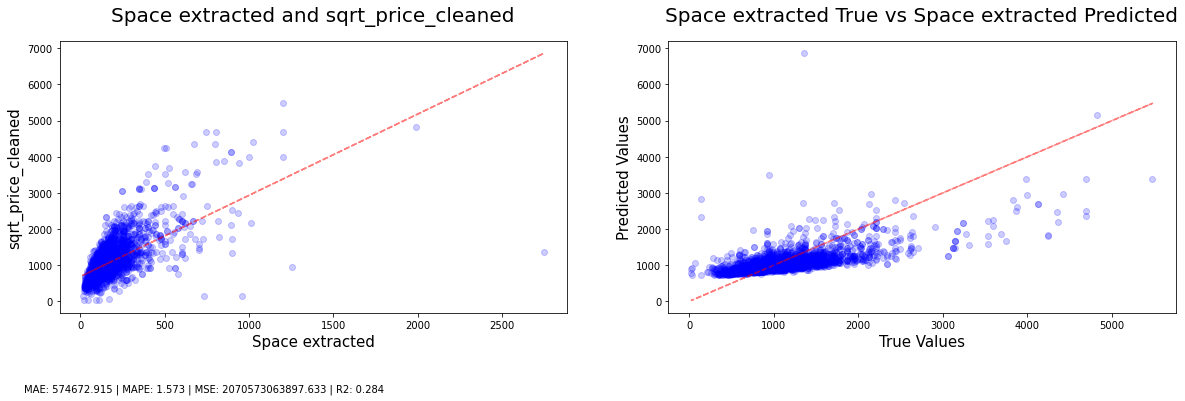

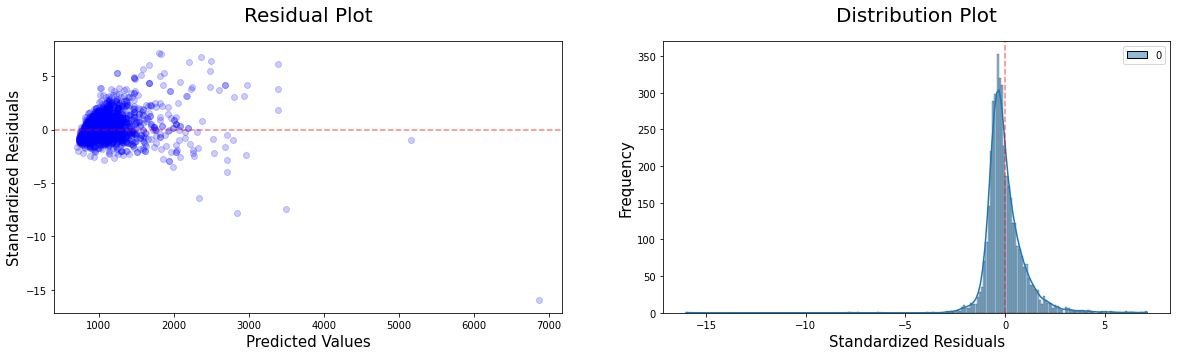

In [16]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "None", y_transform = "sqrt")

## 2.2 Model interpretation and conclusion
- R2 Score of 0.186, MAPE of 0.224, thats not a good linear Model

# 2.3 Simple Lineare Regression with sqrt transformation of y-axis and x-axis

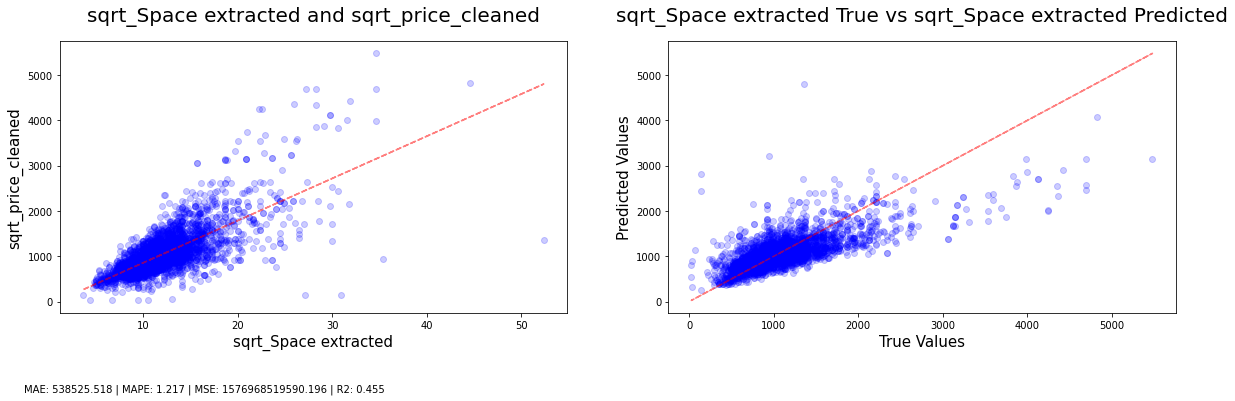

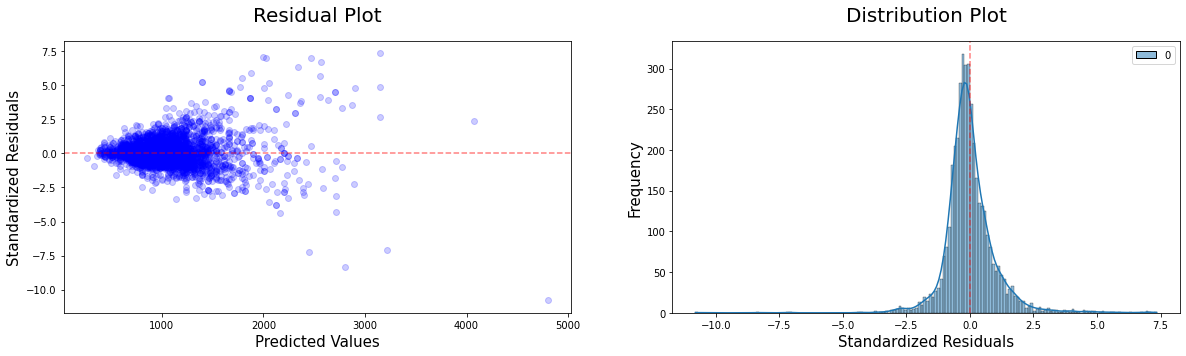

In [17]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "sqrt", y_transform = "sqrt")

## 2.2 Model interpretation and conclusion
- R2 Score of 0.501, MAPE of 0.21, thats not a good linear Model

# 2. Conculsion of sqrt transformation

Our previous Model got a MAPE of 0.908, which is not a good value. <br/>
with our sqrt transformation of both axis, we decreased the MAPE value to 0.21, which is good.

# 3.1 Simple Lineare Regression with log transformation of x-axis

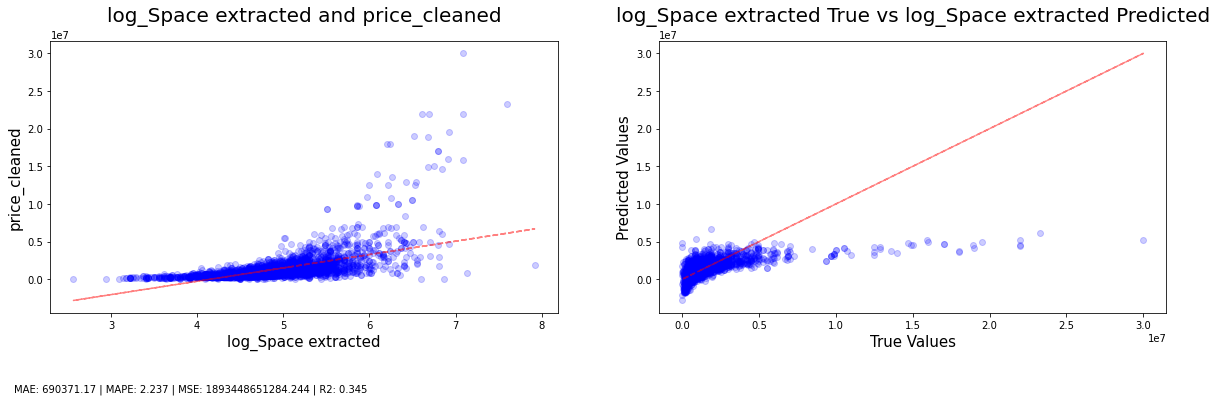

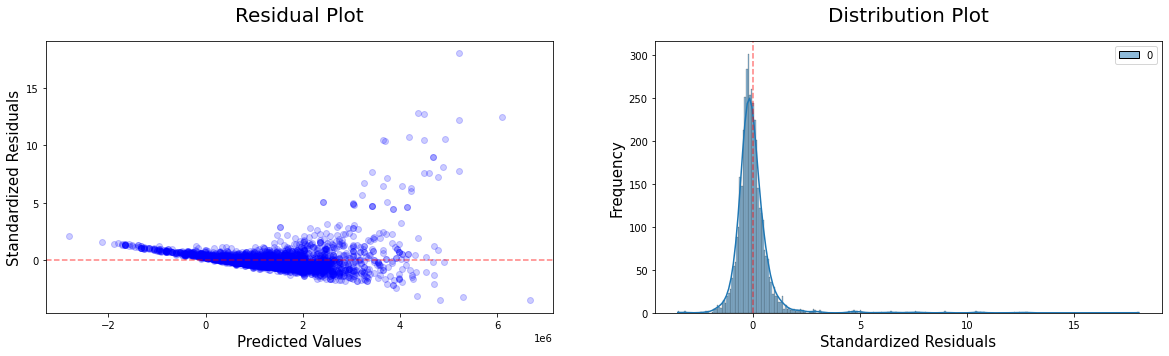

In [18]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "log", y_transform = "None")

## 3.1 Model interpretation and conclusion
- R2 Score of 0.365, MAPE of 1.05, thats not a good linear Model

# 3.2 Simple Lineare Regression with log transformation of y-axis

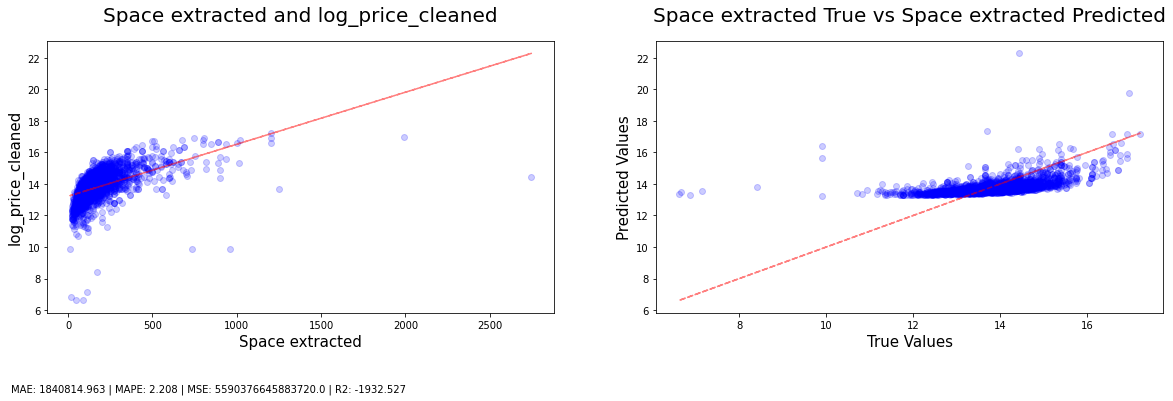

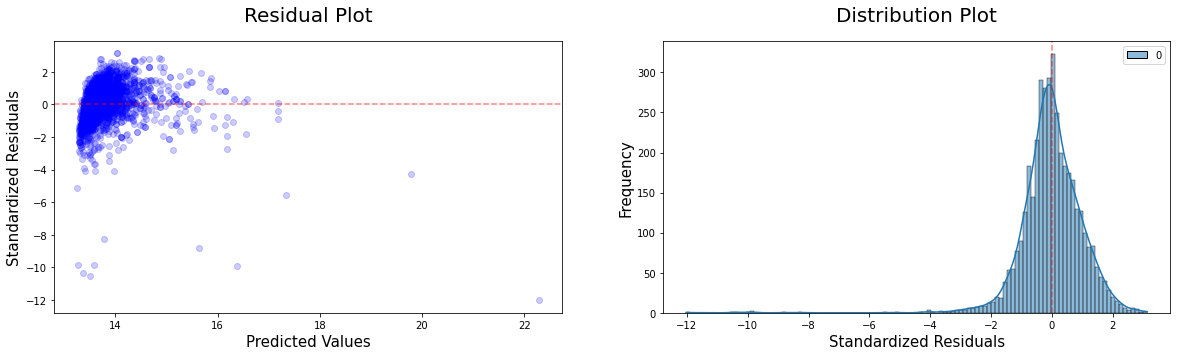

In [19]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "None", y_transform = "log")

## 3.2 Model interpretation and conclusion
- R2 Score of 0.164, MAPE of 0.03, thats not a good linear Model

# 3.3 Simple Lineare Regression with log transformation of x-axis and y-axis

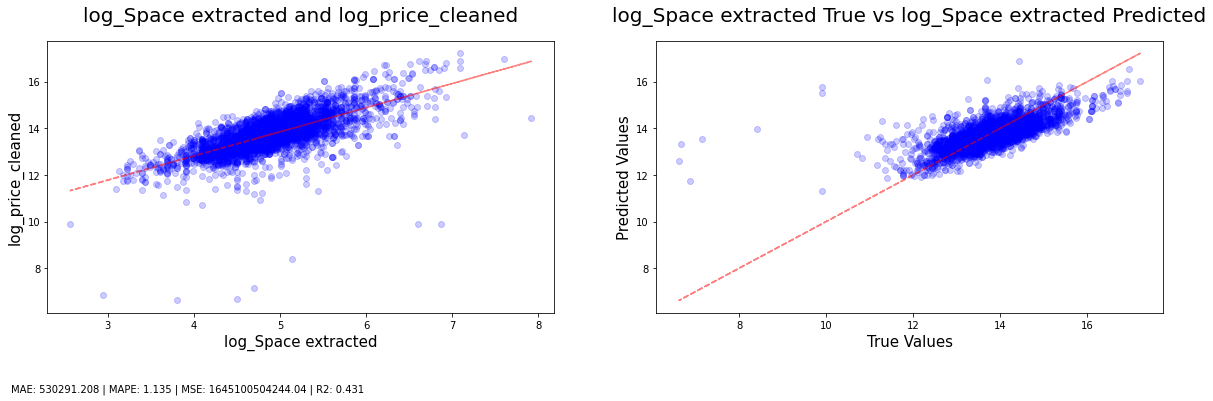

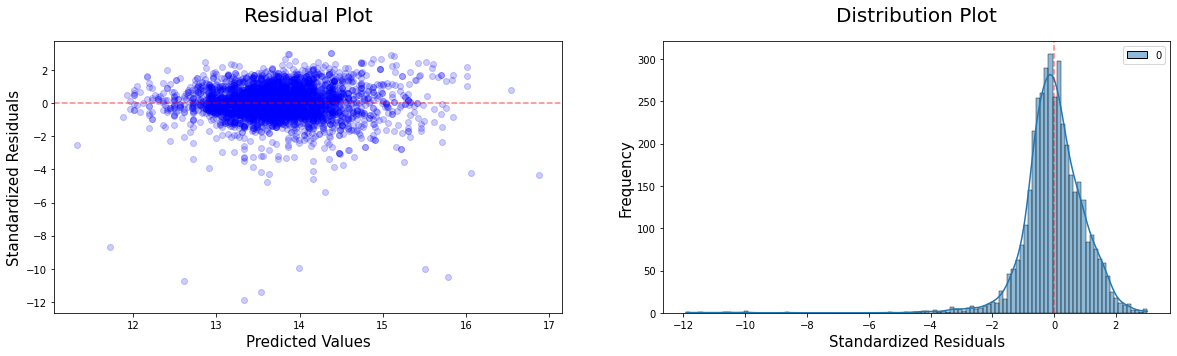

In [20]:
# Using function to create linear regression model and residual plot
linear_regression_model(space_extracted, price_cleaned, x_transform = "log", y_transform = "log")

## 3.3 Model interpretation and conclusion
- R2 Score of 0.493, MAPE of 0.027, thats not a good linear Model

# 3. Conculsion of log transformation

From our previous model without any transformation we got a MAPE of 0.908.  <br/>
If we are transforming with log, the MAPE values decreases to 0.027, so our Models gets better with the log transformation.

If we compare the log and sqrt transformation, we can say, that the log transformation is giving us smaller MAPE. <br/>
therefore we will work with the smaller MAPE value, in other words we will work mit the logartihmic axis transformation.

In the next Chapter we will remove the outliers, and will check, if the MAPE scores deacreses or increases. 

# 4. Removing Outliers

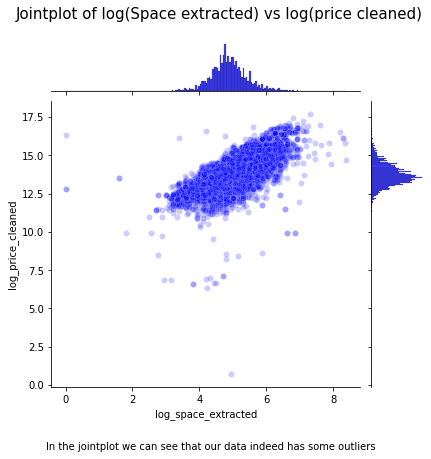

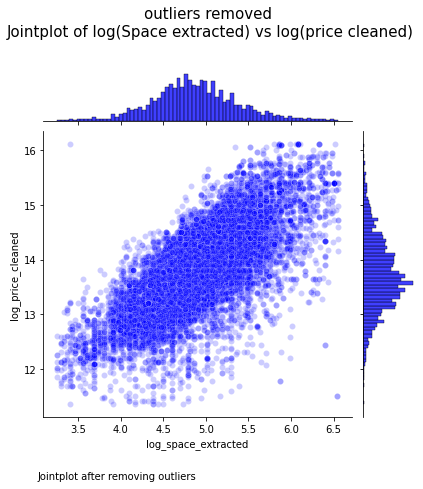

In [21]:
# create x_log and y_log dataframe
log_space_extracted = np.log(space_extracted)
log_price_cleaned = np.log(price_cleaned)
df_log_outliers = pd.DataFrame({'log_space_extracted': log_space_extracted.flatten(), 'log_price_cleaned': log_price_cleaned.flatten()})

# create jointplot
sns.jointplot(x='log_space_extracted', y='log_price_cleaned', data=df_log_outliers, color='blue', alpha = 0.2)
plt.subplots_adjust(top=0.9)
plt.suptitle('Jointplot of log(Space extracted) vs log(price cleaned)', fontsize=15)
plt.xlabel('log(Space extracted)', fontsize=15)
plt.ylabel('log(price_cleaned)', fontsize=15)
plt.figtext(0.1, -0.05, "In the jointplot we can see that our data indeed has some outliers", ha='left', va="bottom" ,fontsize=10)
plt.show() 

# remove every outlier with zscore > 3
from scipy import stats
df_log = df_log_outliers[(np.abs(stats.zscore(df_log_outliers)) < 3).all(axis=1)]

# create jointplot
sns.jointplot(x='log_space_extracted', y='log_price_cleaned', data=df_log, color='blue', alpha = 0.2)
plt.subplots_adjust(top=0.9)
plt.suptitle('outliers removed \nJointplot of log(Space extracted) vs log(price cleaned)', fontsize=15, y = 1.05)
plt.xlabel('log(Space extracted)', fontsize=15)
plt.ylabel('log(price_cleaned)', fontsize=15)
plt.figtext(0.1, -0.05, "Jointplot after removing outliers", ha='left', va="bottom" ,fontsize=10)
plt.show()


In the first Jointplot we cann see, that there are a few outliers in our dataset. 

# 4.1 Simple Lineare Regression without outliers

In [22]:
# Using np.exp to transform log values back to original values for the function! 
df_space_extracted_price_cleaned = np.exp(df_log)

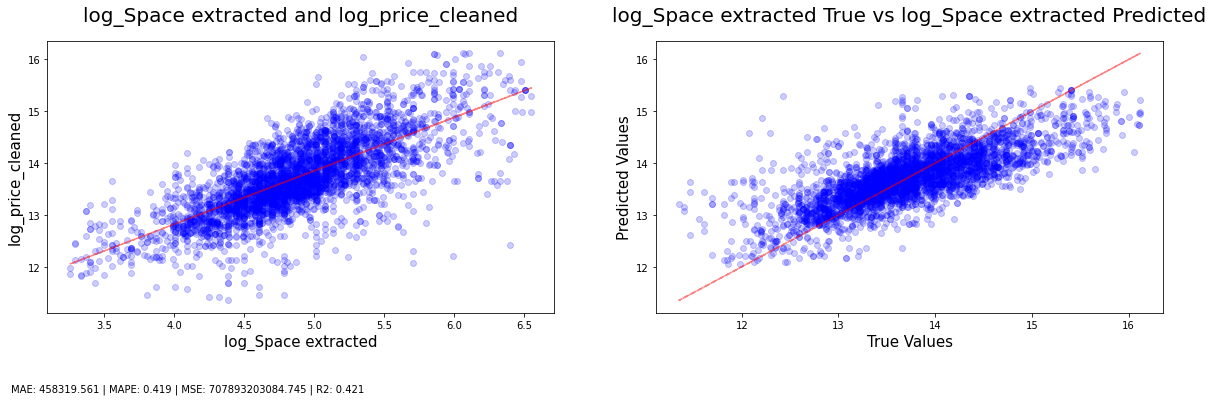

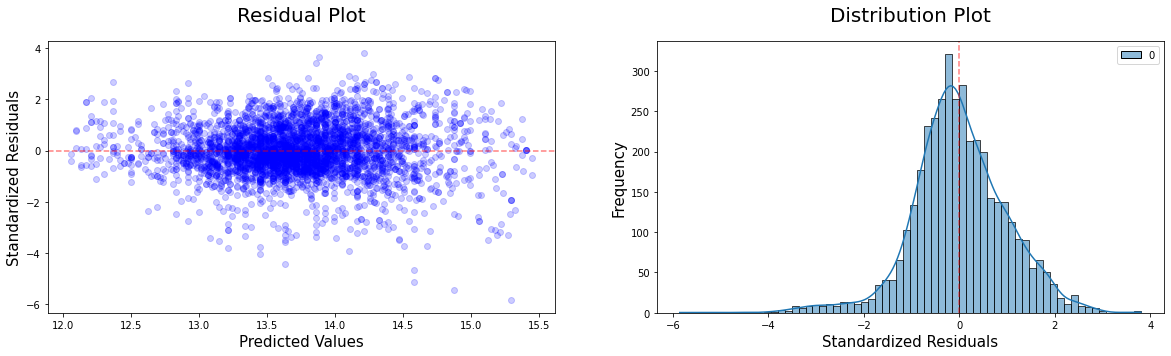

In [23]:
# Using function to create linear regression model and residual plot
linear_regression_model(df_space_extracted_price_cleaned['log_space_extracted'].values.reshape(-1,1), \
                        df_space_extracted_price_cleaned['log_price_cleaned'].values.reshape(-1,1), \
                        x_transform = "log", y_transform = "log")

# 4.2 Linear Regression with crossvalidation

In [24]:
# make cross validation for MAE, MAPE, MSE and R2
from sklearn.model_selection import cross_val_score

# create function to make cross validation
def cross_validation(model, X, y, cv=5):
    # create empty list to store results
    mae = []
    mape = []
    mse = []
    r2 = []

    # make cross validation
    for i in range(cv):
        # split data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        # fit model
        model.fit(X_train, y_train)
        # predict on test data
        y_pred = model.predict(X_test)
        # calculate metrics
        mae.append(mean_absolute_error(y_test, y_pred))
        mape.append(mean_absolute_percentage_error(y_test, y_pred))
        mse.append(mean_squared_error(y_test, y_pred))
        r2.append(r2_score(y_test, y_pred))
    # create dataframe with results
    df_results = pd.DataFrame({'MAE': mae, 'MAPE': mape, 'MSE': mse, 'R2': r2})
    # return dataframe
    return df_results

# create linear regression model
lr = LinearRegression()

# make cross validation
cv_scores = cross_validation(lr, df_space_extracted_price_cleaned['log_space_extracted'].values.reshape(-1,1), \
                    df_space_extracted_price_cleaned['log_price_cleaned'].values.reshape(-1,1), cv=100)

# calculate mean of cross validation results
scores_mean = cv_scores.mean()

# print results
scores_mean


MAE     4.782068e+05
MAPE    4.954418e-01
MSE     6.698600e+11
R2      4.516452e-01
dtype: float64

std angeben 
-> Hypothesentest ob dfs gleich sind oder nicht. 

## 4 Model interpretation and conclusion

With the removal of outliers, our MAPE metrics decreases from 0.027 to 0.025. <br/>
Therefore we can say, that with the removal of our MAPE the models gets better. 